# Predicting the revenue from a loyalty programme

International Essentials is an international supermarket chain.

Shoppers at their supermarkets can sign up for a loyalty program that provides rewards each year to customers based on their spending. The more you spend the bigger the rewards. 

The supermarket would like to be able to predict the likely amount customers in the program will spend, so they can estimate the cost of the rewards. 

This will help them to predict the likely profit at the end of the year.

## Data

The dataset contains records of customers for their last full year of the loyalty program.

| Column Name | Criteria                                                |
|-------------|---------------------------------------------------------|
|customer_id | Unique identifier for the customer. </br>Missing values are not possible due to the database structure. |
|spend | Continuous. </br>The total spend of the customer in their last full year. This can be any positive value to two decimal places. </br>Missing values should be replaced with 0. |
|first_month | Continuous. </br>The amount spent by the customer in their first month of the year. This can be any positive value, rounded to two decimal places. </br>Missing values should be replaced with 0. |
| items_in_first_month | Discrete. </br>The number of items purchased in the first month. Any integer value greater than or equal to zero. </br>Missing values should be replaced by 0. |  
| region | Nominal. </br>The geographic region that the customer is based in. One of four values Americas, Asia/Pacific, Europe, Middle East/Africa. </br>Missing values should be replaced with "Unknown". |
| loyalty_years | Oridinal. </br>The number of years the customer has been a part of the loyalty program. One of five ordered categories, '0-1', '1-3', '3-5', '5-10', '10+'. </br>Missing values should be replaced with '0-1'.|
| joining_month | Nominal. </br>The month the customer joined the loyalty program. One of 12 values "Jan", "Feb", "Mar", "Apr", etc. </br>Missing values should be replaced with "Unknown".|
| promotion | Nominal. </br>Did the customer join the loyalty program as part of a promotion? Either 'Yes' or 'No'. </br>Missing values should be replaced with 'No'.|


In [1]:
# Import the relevant libraries
import pandas as pd

#Common Model Algorithms
from sklearn import model_selection, ensemble, gaussian_process, linear_model, neighbors, naive_bayes, svm, tree, discriminant_analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Task 1: Cleaning the data

Before fitting any models, you need to make sure the data is clean. 

The table above shows what the data should look like. 

Create a cleaned version of the dataframe. 

 - Start with the data in the file `loyalty.csv`. 

 - The output should be a dataframe named `clean_data`. 

 - All column names and values should match the table above.

In [2]:
# Load the dataset
df = pd.read_csv('loyalty.csv')

# Inspecting the data
print(df.head())

#confirming the datatypes
print(df.info())

# Inspecting the descriptive stats
print(df.describe())

   customer_id   spend first_month  items_in_first_month              region  \
0            1  132.68        15.3                     5        Asia/Pacific   
1            2  106.45        16.2                    14        Asia/Pacific   
2            3  123.16       25.26                     7  Middle East/Africa   
3            4  130.60       24.74                     8  Middle East/Africa   
4            5  130.41       25.59                     8  Middle East/Africa   

  loyalty_years joining_month promotion  
0          5-10           Nov        No  
1           0-1           Feb       Yes  
2           10+           Dec       Yes  
3           3-5           Apr        No  
4           3-5           Apr       Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           1246 non-null   int64  
 1   spe

In [3]:
# Cleaning the customer_id column

# Check if all customer_id values are unique
customer_id_unique = df['customer_id'].is_unique

# Check for missing values in customer_id
customer_id_missing_values = df['customer_id'].isnull().any()

print("Customer IDs are unique:", customer_id_unique)
print("There are no missing customer_id values:", not customer_id_missing_values)


Customer IDs are unique: True
There are no missing customer_id values: True


In [4]:
# Cleaning the spend column

# Ensure 'spend' is a float and replace any missing values with 0
df['spend'] = df['spend'].fillna(0).astype(float).round(2)

# Check the descriptive statistics for 'spend'
spend_stats = df['spend'].describe()

# Explicitly check for any negative values
negative_values_exist = (df['spend'] < 0).any()

print(spend_stats)
print("There are only positive values in 'spend':", not negative_values_exist)

count    1246.000000
mean      122.637119
std         9.975102
min       104.290000
25%       112.210000
50%       123.840000
75%       131.092500
max       142.290000
Name: spend, dtype: float64
There are only positive values in 'spend': True


In [5]:
# Cleaning the first_month column

# Replace non-numeric entries with NaN. This uses a regular expression that matches non-numeric values
df['first_month'] = pd.to_numeric(df['first_month'], errors='coerce')

# Ensure 'first_month' is a float, replace any missing values with 0, and round to two decimal places
df['first_month'] = df['first_month'].fillna(0).astype(float).round(2)

# Check for negative values and decide how to handle them
negative_values = df[df['first_month'] < 0]
if not negative_values.empty:
    print("There are negative values in 'first_month'. Consider how you'd like to handle these.")

# Check the descriptive statistics for 'first_month'
first_month_stats = df['first_month'].describe().round(2)
print(first_month_stats)

count    1246.00
mean       17.16
std         6.58
min         0.00
25%        15.75
50%        19.12
75%        21.28
max        26.20
Name: first_month, dtype: float64


In [6]:
# Cleaning the items_in_first_month column

# Replace missing values with 0
df['items_in_first_month'] = df['items_in_first_month'].fillna(0).round().astype(int)

# Check the descriptive statistics for 'items_in_first_month'
items_in_first_month_stats = df['items_in_first_month'].describe()
print(items_in_first_month_stats)

count    1246.000000
mean        9.418138
std         3.000288
min         5.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        15.000000
Name: items_in_first_month, dtype: float64


In [7]:
# Cleaning the region column

# Defining the valid categories for the 'region' column, including 'Unknown'
categories = ['Americas', 'Asia/Pacific', 'Europe', 'Middle East/Africa', 'Unknown']

# Ensuring all values are valid categories, replacing invalid ones with 'Unknown'
df['region'] = df['region'].where(df['region'].isin(categories), 'Unknown')

# Converting the 'region' column to categorical with the predefined categories
df['region'] = pd.Categorical(df['region'], categories=categories)

# Check the unique values to confirm the changes
print(df['region'].unique())

['Asia/Pacific', 'Middle East/Africa', 'Europe', 'Americas']
Categories (4, object): ['Asia/Pacific', 'Middle East/Africa', 'Europe', 'Americas']


In [8]:
# Cleaning the loyalty_years column

# Replace missing values with '0-1'
df['loyalty_years'] = df['loyalty_years'].fillna('0-1')

# Define the valid ordered categories
valid_loyalty_years = ['0-1', '1-3', '3-5', '5-10', '10+']

# Replace any entries not matching the valid categories with '0-1'
df.loc[~df['loyalty_years'].isin(valid_loyalty_years), 'loyalty_years'] = '0-1'

# Convert to an ordered Categorical type
df['loyalty_years'] = pd.Categorical(df['loyalty_years'], categories=valid_loyalty_years, ordered=True)

# Check the changes
print(df['loyalty_years'].dtype)
print(df['loyalty_years'].cat.categories)

category
Index(['0-1', '1-3', '3-5', '5-10', '10+'], dtype='object')


In [9]:
# Cleaning joining_month column

# Replace missing values with 'Unknown'
df['joining_month'] = df['joining_month'].fillna('Unknown')

# List of valid month abbreviations
valid_months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Replace any entry not matching the valid months with 'Unknown'
df.loc[~df['joining_month'].isin(valid_months), 'joining_month'] = 'Unknown'

# Convert to categorical type (nominal) without imposing order
df['joining_month'] = pd.Categorical(df['joining_month'], categories=valid_months + ['Unknown'], ordered=False)

# To check the changes
print(df['joining_month'].dtype)
print(sorted(df['joining_month'].unique()))

category
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Unknown']


In [10]:
# Cleaning the promotion column 

# Display the unique values in the 'promotion' column
unique_promotion_values = df['promotion'].unique()
print(sorted(unique_promotion_values))

# Standardize the 'promotion' column to have only 'Yes' or 'No'
df['promotion'] = df['promotion'].str.lower().map({'yes': 'Yes', 'no': 'No'}).fillna('No')

# Convert to a nominal categorical type without imposing order
df['promotion'] = pd.Categorical(df['promotion'], categories=['Yes', 'No'], ordered=False)

# # Checking the dtype and unique values to confirm the changes
print(df['promotion'].dtype)
print(sorted(df['promotion'].unique()))

['NO', 'No', 'YES', 'Yes']
category
['No', 'Yes']


In [11]:
# rename df to clean_data 
clean_data = df.copy()

print(clean_data.head())
print(clean_data.info())

import pandas as pd

# Iterate over each column in the DataFrame
for column in clean_data.columns:
    # Check if the column is of dtype 'category' using isinstance to ensure compatibility
    if isinstance(clean_data[column].dtype, pd.CategoricalDtype):
        print(f"Unique values in '{column}': {sorted(clean_data[column].unique())}")



   customer_id   spend  first_month  items_in_first_month              region  \
0            1  132.68        15.30                     5        Asia/Pacific   
1            2  106.45        16.20                    14        Asia/Pacific   
2            3  123.16        25.26                     7  Middle East/Africa   
3            4  130.60        24.74                     8  Middle East/Africa   
4            5  130.41        25.59                     8  Middle East/Africa   

  loyalty_years joining_month promotion  
0          5-10           Nov        No  
1           0-1           Feb       Yes  
2           10+           Dec       Yes  
3           3-5           Apr        No  
4           3-5           Apr       Yes  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   customer_id           1246 non-null   int64   

# Task 2: Drawing consumer behaviour insights

The team at International Essentials have told you that they have always believed that the number of years in the loyalty scheme is the biggest driver of spend. 

Producing a table showing the difference in the average spend by number of years in the loyalty programme along with the variance to investigate this question for the team.

 - You should start with the data in the file `loyalty.csv`.

 - Your output should be a data frame named `spend_by_years`.

 - It should include the three columns `loyalty_years`, `avg_spend`, `var_spend`. 

 - Your answers should be rounded to 2 decimal places.   

In [ ]:
# Calculate average spend and variance by loyalty_years
spend_by_years = clean_data.groupby('loyalty_years')['spend'].agg(['mean', 'var']).reset_index()
spend_by_years.columns = ['loyalty_years', 'avg_spend', 'var_spend']

# Round the values to 2 decimal places
spend_by_years['avg_spend'] = spend_by_years['avg_spend'].round(2)
spend_by_years['var_spend'] = spend_by_years['var_spend'].round(2)

# Display the resulting dataframe
print(spend_by_years)

In [ ]:
fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(15,30))

sns.boxplot(y = 'region', x = 'spend', hue = 'promotion', data = clean_data, ax = axis1)
axis1.set_title('Region vs Spend Comparison')

sns.violinplot(y = 'loyalty_years', x = 'spend', hue = 'promotion', data = clean_data, split = True, ax = axis2)
axis2.set_title('Loyalty vs Spend Comparison')

sns.boxplot(y = 'joining_month', x ='spend', hue = 'promotion', data = clean_data, ax = axis3)
axis3.set_title('Month Joined vs Spend Comparison')

In [ ]:
# Visualizing the data

#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(clean_data)

# Task 3: Modelling the data

Fit a baseline model to predict the spend over the year for each customer.

 1. Fit your model using the data contained in `train.csv` </br></br> 

 2. Use `test.csv` to predict new values based on your model. You must return a dataframe named `base_result`, that includes `customer_id` and `spend`. The `spend` column must be your predicted values.

In [16]:
# One-hot encode categorical columns
clean_data_encoded = pd.get_dummies(clean_data, columns=['region', 'loyalty_years', 'joining_month', 'promotion'])

# Define your target variable
Target = 'spend'

# Machine Learning Algorithm (MLA) Selection and Initialization for regression
MLA = [
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
    linear_model.LinearRegression(),
    linear_model.RidgeCV(),
    neighbors.KNeighborsRegressor(),
    svm.SVR(),
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    XGBRegressor()  # Note: Removed enable_categorical=True due to compatibility issues
]

# Cross-validation and MLA comparison
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.7, random_state=0)
MLA_columns = [
    'MLA Name', 
    'MLA Parameters',
    'MLA Train MSE Mean',  # Using Mean Squared Error to assess model accuracy
    'MLA Test MSE Mean', 
    'MLA Test MSE 3*STD',  # Reflects variability in test MSE
    'MLA Time'
]
MLA_compare = pd.DataFrame(columns=MLA_columns)

row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross-validation, ensure to drop the Target column for X, and use Target directly for y
    cv_results = model_selection.cross_validate(alg, clean_data_encoded.drop(columns=[Target]), clean_data_encoded[Target], cv=cv_split, scoring='neg_mean_squared_error', return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train MSE Mean'] = -cv_results['train_score'].mean()  # Negate to make positive
    MLA_compare.loc[row_index, 'MLA Test MSE Mean'] = -cv_results['test_score'].mean()  # Negate to make positive
    MLA_compare.loc[row_index, 'MLA Test MSE 3*STD'] = cv_results['test_score'].std()*3
    row_index += 1

# Sort and display the results
MLA_compare.sort_values(by=['MLA Test MSE Mean'], ascending=True, inplace=True)  # Lower MSE is better
MLA_compare


,MLA Name,MLA Parameters,MLA Train MSE Mean,MLA Test MSE Mean,MLA Test MSE 3*STD,MLA Time
11,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.003858,0.5021,0.344593,0.062576
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.269169,0.530869,0.353793,0.092734
2,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",0.0,0.626259,0.484388,0.268162
4,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.105515,0.845706,0.663499,0.285782
1,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.130476,0.869536,0.707006,0.032995
10,ExtraTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",-0.0,1.091166,0.690015,0.004412
9,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_de...",0.0,1.111701,1.064209,0.005061
5,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",1.195712,1.296379,0.33222,0.002586
6,RidgeCV,"{'alpha_per_target': False, 'alphas': array([ ...",1.195777,1.296399,0.332522,0.003501
0,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",3.743381,4.014258,0.835223,0.084863


Text(0, 0.5, 'Algorithm')

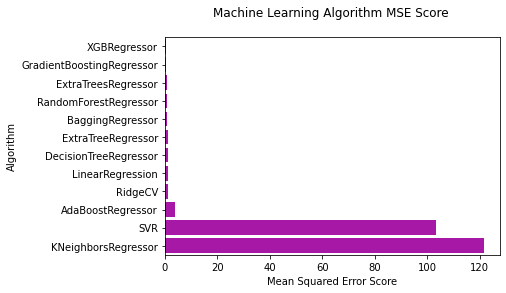

In [17]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test MSE Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm MSE Score \n')
plt.xlabel('Mean Squared Error Score')
plt.ylabel('Algorithm')


In [19]:
# Example for one model
predicted = XGBRegressor.predict(X_test)  # model is one of your trained MLAs
residuals = y_test - predicted

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()


NameError: name 'X_test' is not defined